In [1]:
import wandb
api = wandb.Api()


In [4]:
from pathlib import Path
import json
import pandas as pd
import re

algo_mapping = {
    "0sds7bw5": "CQL",
    "z64aipi0": "$\delta$ = 1",
    "i87w77ty": "$\delta$ = 2",
    "ft6049mq": "$\delta$ = $\delta_\max$",
}

source_ts_amounts= [n * 2048 * 2 for n in [4, 6, 8]]
source_ts = 'data timesteps'
algo = 'algorithm'

def generate():
    for path in Path('artifacts').rglob('*.json'):
        pattern = r"run-(\w+)-tablereturns:v\d+"
        with path.open() as f:
            table = json.load(f)
        df = pd.DataFrame(table['data'], columns=table['columns'])
        match = re.search(pattern, str(path))
        print(path)
        if match is None:
            continue
        run_id = match.group(1)
        try:
            df[algo] = algo_mapping[run_id]
        except KeyError:
            continue

        # df[source_ts] = source_ts_amounts[id_within_sweep]
        yield df
        
df = pd.concat(list(generate()), ignore_index=True)

x = 'timestep'
y = 'discounted returns'

df = df.rename(columns={'returns': y})
df.loc[:, x] = df.groupby(['idx', algo, source_ts, 'step'])[x].cumsum()
def keep_last_n_steps(group, n=10):
    steps = sorted(group['step'].unique())
    top_n = steps[-n:]
    return group[group['step'].isin(top_n)]

df = df.groupby([algo, source_ts], group_keys=False).apply(keep_last_n_steps)
df = df.sort_values(by=[algo, source_ts, 'step', 'idx', x])

bin_size = 20
df[x] = (df[x] // bin_size ) * bin_size
df = df[df[x] < 800]
df

artifacts/run-ft6049mq-tablereturns:v15/table/returns.table.json
artifacts/run-z64aipi0-tablereturns:v8/table/returns.table.json
artifacts/run-ft6049mq-tablereturns:v12/table/returns.table.json
artifacts/run-z64aipi0-tablereturns:v1/table/returns.table.json
artifacts/run-z64aipi0-tablereturns:v6/table/returns.table.json
artifacts/run-0sds7bw5-tablereturns:v3/table/returns.table.json
artifacts/run-0sds7bw5-tablereturns:v4/table/returns.table.json
artifacts/run-z64aipi0-tablereturns:v7/table/returns.table.json
artifacts/run-z64aipi0-tablereturns:v0/table/returns.table.json
artifacts/run-ft6049mq-tablereturns:v13/table/returns.table.json
artifacts/run-z64aipi0-tablereturns:v9/table/returns.table.json
artifacts/run-ft6049mq-tablereturns:v14/table/returns.table.json
artifacts/run-0sds7bw5-tablereturns:v5/table/returns.table.json
artifacts/run-0sds7bw5-tablereturns:v2/table/returns.table.json
artifacts/run-ft6049mq-tablereturns:v3/table/returns.table.json
artifacts/run-ft6049mq-tablereturns:

,episode,idx,discounted returns,timestep,step,algorithm
9077,0,0,0.000000,80,48000,$\delta$ = $\delta_\max$
9097,1,0,1.489890,180,48000,$\delta$ = $\delta_\max$
9117,2,0,1.990000,280,48000,$\delta$ = $\delta_\max$
9137,3,0,1.645072,360,48000,$\delta$ = $\delta_\max$
9157,4,0,0.000000,440,48000,$\delta$ = $\delta_\max$
...,...,...,...,...,...,...
6407,2,19,1.763906,280,54000,CQL
6427,3,19,1.494839,380,54000,CQL
6447,4,19,0.000000,480,54000,CQL
6464,5,19,1.970100,500,54000,CQL


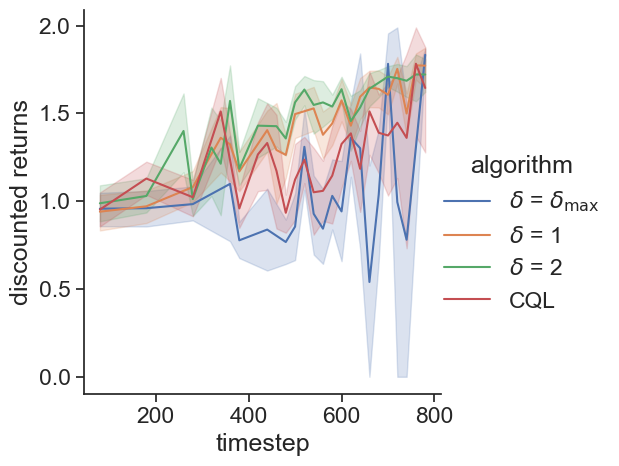

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.reset_defaults()
sns.set(font_scale=1.5)
sns.set_style('ticks')

g = sns.relplot(x=x, y=y, kind='line', hue=algo, data=df, col=source_ts)
plt.show()